# Tutorial
Learn how to use the *Mira-Titan* emulator for the halo mass function. This tutorial is built from a jupyter notebook hosted on the [MiraTitanHMFemulator GitHub repository](https://github.com/SebastianBocquet/MiraTitanHMFemulator/blob/master/tutorial.ipynb).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import MiraTitanHMFemulator

print("Version", MiraTitanHMFemulator.__version__)

Version 0.1.1


## Initialize the emulator
This may take a few seconds: the code pre-computes a bunch of matrix inversions (actually, Cholesky decompositions).

In [2]:
HMFemu = MiraTitanHMFemulator.Emulator()

## Input cosmology
Let's define a set of cosmology parameter for which we want the mass function. In case you are unsure about the parameters and their ranges, you can grab that from the emulator instance we just created. Don't worry, the emulator will check that your cosmology is valid (see example "Validation of input cosmology" below).

### Note about dark energy equation-of-state parametrization
The emulator itself works in the space of $(w_0, w_b)$, where $w_b = (-w_0 -w_a)^{1/4}$ (see paper). The user is expected to provide the parameters in the usual space of $(w_0, w_a)$ and the code will handle the conversion for you.

In [3]:
HMFemu.param_limits

{'Ommh2': (0.12, 0.155),
 'Ombh2': (0.0215, 0.0235),
 'Omnuh2': (0, 0.01),
 'n_s': (0.85, 1.05),
 'h': (0.55, 0.85),
 'sigma_8': (0.7, 0.9),
 'w_0': (-1.3, -0.7),
 'w_b': (0.3, 1.3)}

In [4]:
fiducial_cosmo = {'Ommh2': .3*.7**2,
                  'Ombh2': .022,
                  'Omnuh2': .0006,
                  'n_s': .96,
                  'h': .7,
                  'w_0': -1,
                  'w_a': 0,
                  'sigma_8': .8,
                 }

## Call the emulator
It's as easy as passing the requested cosmology, redshift, and mass. The emulator return the mass function and the relative error:

In [5]:
res = HMFemu.predict(fiducial_cosmo, 0, 1e14)
print(res)

(array([[2.69632829e-05]]), array([[0.00295608]]))


Admittedly, looking at a single mass and redshift is not that useful. So let's ask for a couple of redshifts and an array of masses:

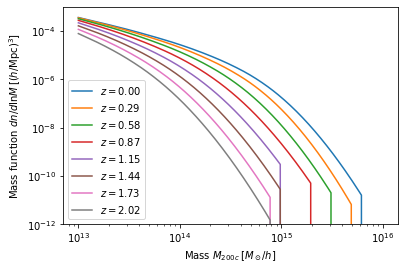

In [6]:
z = np.linspace(0,2.02,8)
m = np.logspace(13,16,301)
res = HMFemu.predict(fiducial_cosmo, z, m)

for i,_z in enumerate(z):
    plt.loglog(m, res[0][i], label='$z=%.2f$'%_z)
plt.ylim(1e-12, 1e-3)
plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Mass function $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

### Note:
The sharp drops at high mass are due to the finite range of validity of the emulator (see the paper for details). You may of course set up an extrapolation to even larger masses at your own risk. The same applies to extrapolations to lower masses. Note that at low mass $10{13}M_\odot/h<M<10^{13.1}M_\odot/h$, our mass function is a power law in mass so extrapolation should not be a problem from the technical point of view. But again, we do not guarantee the accuracy of such an extrapolation.

(If you want to make a nicer looking plot you can set the high-mass values to NAN so they get omitted from the plot. We didn't want to have the emulator return NANs for obvious reasons.)

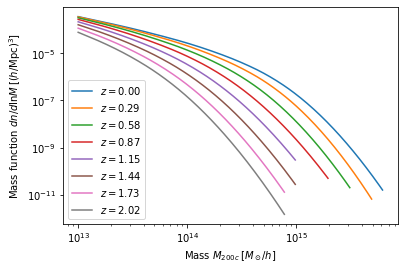

In [7]:
# Replace the ~0 values with NANs
res[0][res[0]<1e-12] = np.nan

for i,_z in enumerate(z):
    plt.loglog(m, res[0][i], label='$z=%.2f$'%_z)
plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Mass function $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

OK, now we understand the basic concept. Let's try another cosmology with dynamical dark energy just for fun.

In [8]:
w0wa_cosmo = {'Ommh2': .3*.7**2,
            'Ombh2': .022,
            'Omnuh2': .0006,
            'n_s': .96,
            'h': .7,
            'w_0': -1.3,
            'w_a': -1,
            'sigma_8': .8,
           }

res_w0wa = HMFemu.predict(w0wa_cosmo, z, m)
res_w0wa[0][res_w0wa[0]<1e-12] = np.nan

In [9]:
colors=['C%s'%i for i in range(3)]
for i in [0,2,4,6]:
    plt.loglog(m, res[0][i,:], color='C%d'%i, label='$z=%.2f$ fiducial_cosmo'%z[i])
    plt.loglog(m, res_w0wa[0][i,:], color='C%d'%i, label='$z=%.2f$ w0wa_cosmo'%z[i], ls=':')
plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Mass function $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

## Emulator uncertainty
Now let's look at the built-in error estimate on the emulated mass function.

### Important note!
The errors are estimated from stochastic draws. Therefore, to reproduce the errors exactly for a given cosmology, you need to set numpy's random seed first. If you don't (which is fine) you'll simply get a new realization of the error estimate.
As above for the mass function, the error is set to 0 outside of the mass range for which the emulator is defined.

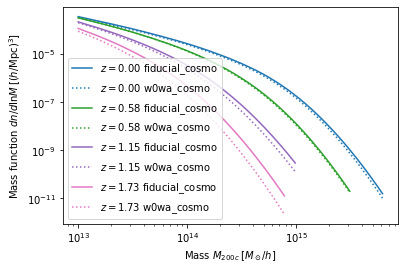

In [10]:
# Set your favorite random seed (optional, but allows to reproduce the plots below exactly)
np.random.seed(1328)
# Call the emulator (less redshifts this time for better readability)
z = np.array([0, .5, 1, 2])
m = np.logspace(13,16,301)
res = HMFemu.predict(fiducial_cosmo, z, m)
# As before, set 0 error to NAN for nicer plots!
res[1][res[1]==0] = np.nan

Let's visualize the error on the emulated mass function. As expected, the noise increases with mass and redshift, because the input mass functions are limited by shot noise (and sample variance at low mass) in the halo catalogs. The jumps at high mass are due to the interpolation of the underlying emulator output and shouldn't cause any trouble.

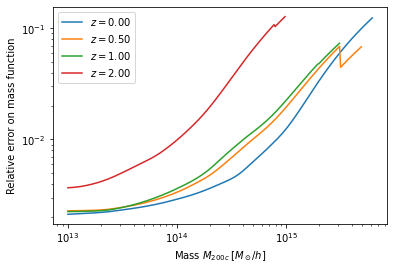

In [11]:
for i,_z in enumerate(z):
    plt.loglog(m, res[1][i], color='C%d'%i, label='$z=%.2f$'%_z)
plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Relative error on mass function')
plt.legend();

Also note that the emulator precision depends on the location in parameter space: If an input model is "close", the error is smaller than if the closest input cosmology is "far away". So let's compare the errors on the fiducial cosmology and the dynamical dark energy model:

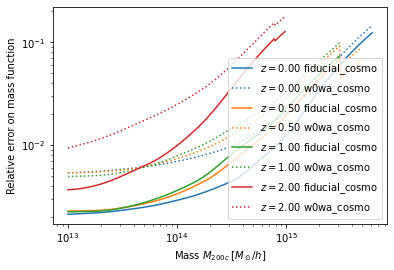

In [12]:
res_w0wa = HMFemu.predict(w0wa_cosmo, z, m)
res_w0wa[1][res_w0wa[1]==0] = np.nan

for i,_z in enumerate(z):
    plt.loglog(m, res[1][i], color='C%d'%i, label='$z=%.2f$ fiducial_cosmo'%_z)
    plt.loglog(m, res_w0wa[1][i], color='C%d'%i, label='$z=%.2f$ w0wa_cosmo'%_z, ls=':')

plt.xlabel('Mass $M_{200c}\,[M_\odot/h]$')
plt.ylabel('Relative error on mass function')
plt.legend(loc='lower right');

## Validation of input cosmology
Now that we've seen the emulator in action, let's go back one step. As mentioned earlier, the emulator validates your input cosmology. For example, if you miss one parameter, you get:

In [13]:
bad_cosmo = {'Ommh2': .3*.7**2,
             'Ombh2': .022,
             'Omnuh2': .0006,
             'n_s': .96,
             'h': .7,
             'w_0': -1,
             'w_a': 0,
#              'sigma_8': .8,
            }

try:
    HMFemu.predict(bad_cosmo, z, m)
except Exception as e:
    print(repr(e))

KeyError('You did not provide sigma_8')


Or if you set a parameter outside the range:

In [14]:
bad_cosmo = {'Ommh2': .3*.7**2,
             'Ombh2': .022,
             'Omnuh2': .0006,
             'n_s': .96,
             'h': .7,
             'w_0': -1,
             'w_a': 0,
             'sigma_8': 1.8,
            }

try:
    HMFemu.predict(bad_cosmo, z, m)
except Exception as e:
    print(repr(e))

ValueError('Parameter sigma_8 is 1.8000 but must be <= 0.9000')


If you don't want the emulator to raise an exception, for example because you are running an MCMC chain, you can also validate your input cosmology before calling the emulator:

In [15]:
is_valid = HMFemu.validate_params(bad_cosmo)
print("Input cosmology 'bad_cosmo' is valid: %s"%is_valid)

Input cosmology 'bad_cosmo' is valid: False


In [16]:
is_valid = HMFemu.validate_params(fiducial_cosmo)
print("Input cosmology 'fiducial_cosmo' is valid: %s"%is_valid)

Input cosmology 'fiducial_cosmo' is valid: True


### Cosmological parameter names
I tend to forget if the code expects, e.g., `w_0` or `w0` as an input parameter. Therefore, starting with version 0.0.1, you can provide parameter names with or without underscores.

In [17]:
no_underscore_cosmo = {'Ommh2': .3*.7**2,
                       'Ombh2': .022,
                       'Omnuh2': .0006,
                       'ns': .96,
                       'h': .7,
                       'w0': -1,
                       'wa': 0,
                       'sigma8': .8,}
is_valid = HMFemu.validate_params(no_underscore_cosmo)
print("Input cosmology without underscores is valid: %s"%is_valid)

Input cosmology without underscores is valid: True


## Advanced stuff
The above examples should cover most common use cases. But in case you are curious, here are some additional features:

### Optional arguments
When calling `HMFemu.predict()` you may also pass `get_errors=False` if you don't need the error estimates and you care about the slight improvement in execution speed. The error array will return 0.
You can also pass the number of random draws `N_draw` from which the emulator code estimates the error on the mass function. Default is 1000.

### Access to the "raw" emulator output
If you feel like you need more fine-grained control over the interpolation machinery (in mass and redshift, not in cosmology!) then you can also access the "raw" output from the underlying emulator (which is what we discuss in our paper) by calling `HMFemu.predict_raw_emu()`.

In [18]:
raw_res = HMFemu.predict_raw_emu(fiducial_cosmo)

Now let's look at the output stored in the `raw_res` dictionary. Each (numerical) key corresponds to a redshift for which the emulator computed the HMF. There's a `Units` key, too.

In [19]:
print(raw_res.keys())

dict_keys(['Units', 2.02, 1.61, 1.01, 0.656, 0.434, 0.242, 0.101, 0.0])


In [20]:
print(raw_res['Units'])

log10_M is log10(Mass in [Msun/h]), HMFs are given in dn/dlnM [(h/Mpc)^3]


So far, nothing too surprising. Now let's look into one of the redshift outputs:

In [21]:
print("Keys of res[0.0]:\t", raw_res[0.0].keys())
print("Redshift of res[0.0]:\t", raw_res[0.0]['redshift'])
print("Array of (log) masses:\t", raw_res[0.0]['log10_M'])
print("The emulated HMF\t", raw_res[0.0]['HMF'])

Keys of res[0.0]:	 dict_keys(['redshift', 'log10_M', 'HMF'])
Redshift of res[0.0]:	 0.0
Array of (log) masses:	 [13.    13.001 13.002 ... 15.797 15.798 15.799]
The emulated HMF	 [3.58216702e-04 3.57405814e-04 3.56596762e-04 ... 1.42782592e-11
 1.40608088e-11 1.38465487e-11]


The emulator interface discussed above uses these mass functions to set up a grid in mass and redshift within which we can interpolate at will.

## That's it!
You now know how to use the *Mira-Titan* HMF emulator. Please don't hesitate to reach out to us!